# DIS-low
can we get the KOSMOS templates to play nice with DIS-low (esp. missing the He lamp) ?

In [1]:
%matplotlib widget
 # need notebook backend for interaction
# %matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

# file-handling stuff for user, options abound! I like Tables and Pandas DataFrames
import pandas as pd
from astropy.table import Table
from astropy import units as u
from specutils import Spectrum1D

# import the local dev version
import sys
sys.path.insert(0,'/Users/james/Dropbox/research_projects/pykosmos')

import pykosmos as pk
pk.__version__

'0.3.7.4'

In [2]:
# should we make a whole bunch of plots?
DISPLAY = True

In [3]:
rarcfile = '/Users/james/Dropbox/research_projects/kosmos-testing/arc.0016r.fits'
barcfile = '/Users/james/Dropbox/research_projects/kosmos-testing/arc.0016b.fits'

# read and process in the ARC LAMP, just like a normal spectrum
barcimg = pk.proc(barcfile,trim=True)
rarcimg = pk.proc(rarcfile,trim=True)

sci_trace = np.ones(barcimg.shape[1])*455

 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]


Text(0.5, 1.0, '/Users/james/Dropbox/research_projects/kosmos-testing/arc.0016r.fits')

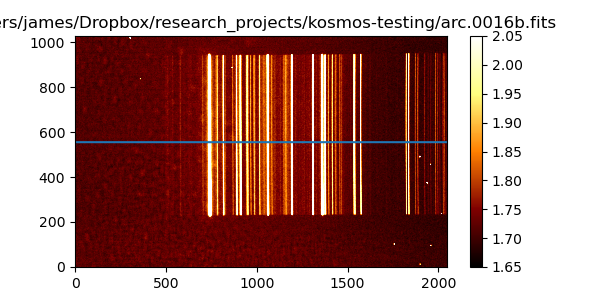

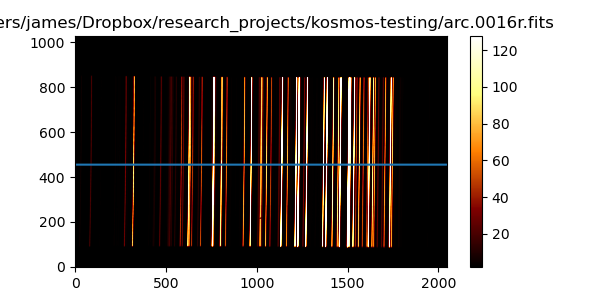

In [4]:
plt.figure(figsize=(6,3))
plt.imshow(barcimg, origin='lower', aspect='auto', cmap=plt.cm.afmhot)
plt.plot(np.arange(len(sci_trace)), sci_trace+100) # for illustration, overplot the trace 
plt.clim(np.percentile(barcimg, (5, 97)))
cb = plt.colorbar()
plt.title(barcfile)

plt.figure(figsize=(6,3))
plt.imshow(rarcimg, origin='lower', aspect='auto', cmap=plt.cm.afmhot)
plt.plot(np.arange(len(sci_trace)), sci_trace) # for illustration, overplot the trace 
plt.clim(np.percentile(rarcimg, (5, 97)))
cb = plt.colorbar()
plt.title(rarcfile)

In [5]:
rex = pk.BoxcarExtract(rarcimg, sci_trace, apwidth=5, skysep=5, skywidth=5, bkgd_sub=False, Saxis=0, Waxis=1)
bex = pk.BoxcarExtract(barcimg, sci_trace+100, apwidth=5, skysep=5, skywidth=5, bkgd_sub=False, Saxis=0, Waxis=1)

/var/folders/8t/yh7p62792_b_y17g3f6wk0wm0000gn/T/ipykernel_44384/1352405594.py:1: DeprecationWarning: PyKOSMOS BoxcarExtract is now a wrapper for functions within specreduce.extract.
  rex = pk.BoxcarExtract(rarcimg, sci_trace, apwidth=5, skysep=5, skywidth=5, bkgd_sub=False, Saxis=0, Waxis=1)
/var/folders/8t/yh7p62792_b_y17g3f6wk0wm0000gn/T/ipykernel_44384/1352405594.py:2: DeprecationWarning: PyKOSMOS BoxcarExtract is now a wrapper for functions within specreduce.extract.
  bex = pk.BoxcarExtract(barcimg, sci_trace+100, apwidth=5, skysep=5, skywidth=5, bkgd_sub=False, Saxis=0, Waxis=1)


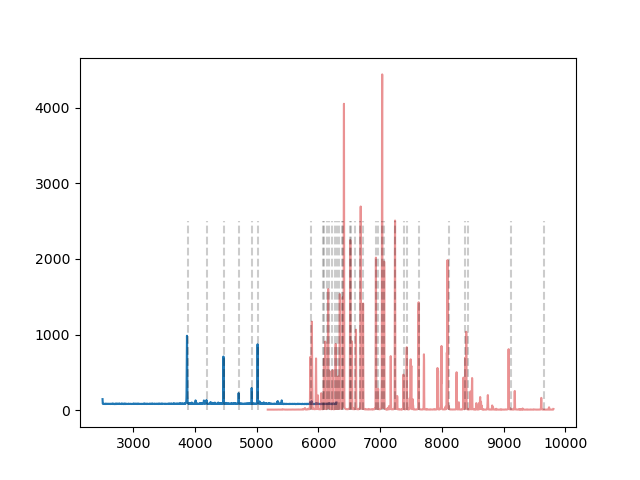

In [6]:
wapproxb = (np.arange(barcimg.shape[1]) - barcimg.shape[1]/2) * barcimg.header['DISPDW'] + barcimg.header['DISPWC']
wapproxb = wapproxb * u.angstrom

wapproxr = (np.arange(rarcimg.shape[1]) - rarcimg.shape[1]/2)[::-1] * rarcimg.header['DISPDW'] + rarcimg.header['DISPWC']
wapproxr = wapproxr * u.angstrom

# The old IRAF-style linelists just have 2 col: (wavelength, line name)
henear_tbl = Table.read('../pykosmos/resources/linelists/apohenear.dat', 
                        names=('wave', 'name'), format='ascii')

henear_tbl['wave'].unit = u.angstrom
apo_henear = henear_tbl['wave']

plt.figure()
plt.plot(wapproxb, bex.flux.value*10)
plt.plot(wapproxr, rex.flux, c='C3', alpha=0.5)

plt.vlines(apo_henear.data, 0, 2500, linestyles='--', color='k', alpha=0.2)


In [7]:
pk.loadarctemplate(help=True)
tmpl = pk.loadarctemplate('DIS_R300.spec')
xpts,wpts = pk.identify_dtw(rex, tmpl, peak_spline=True, return_peaks=True)
print(len(xpts))

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

47


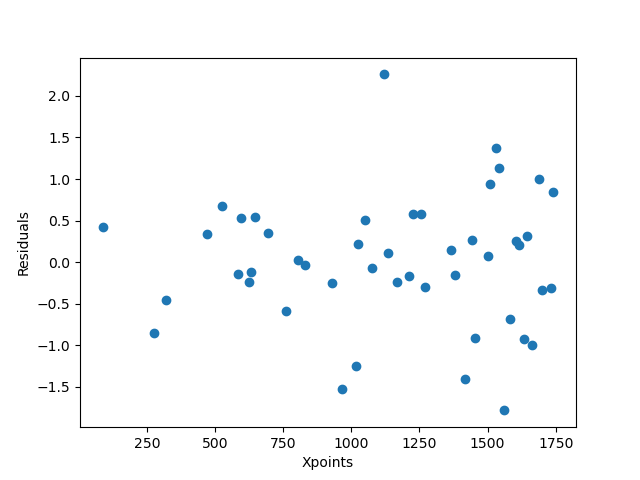

In [8]:
plt.figure()
rfit = pk.fit_wavelength(rex, xpts, wpts, mode='spline', display=True)

In [9]:
from scipy.signal import find_peaks

Text(0, 0.5, 'flux')

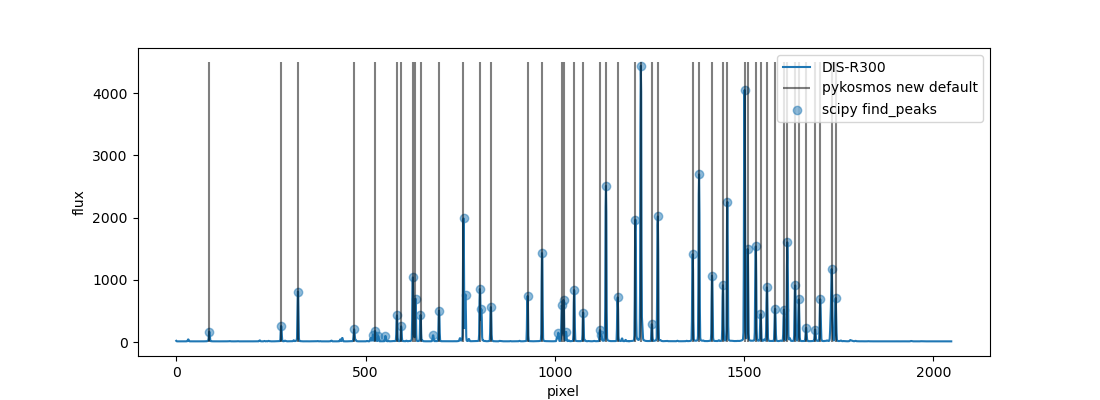

In [10]:
plt.figure(figsize=(11,4))
plt.plot(rex.spectral_axis.value, rex.flux.value, label='DIS-R300')
plt.vlines(xpts, 0, 4500, label='pykosmos new default', color='k', alpha=0.5)

mm = np.mean(rex.flux.value) - np.median(rex.flux.value)

speaks, _ = find_peaks(rex.flux.value, height=mm, distance=3)
plt.scatter(rex.spectral_axis.value[speaks], rex.flux.value[speaks], alpha=0.5, label='scipy find_peaks')

plt.legend()
plt.xlabel('pixel')
plt.ylabel('flux')

In [11]:
np.diff(xpts)

array([189.82014562,  44.23544592, 148.49947199,  55.18050405,
        57.67819583,  11.29412395,  30.68109841,   7.0528709 ,
        13.29208311,  48.92680003,  64.59929782,  44.27085408,
        27.97308128,  96.8995657 ,  38.44447308,  52.10961844,
         4.63452239,  28.12059179,  23.74782147,  45.00373454,
        15.07046766,  30.84558794,  47.02767932,  14.32143031,
        29.00108088,  15.62229655,  92.20505491,  16.87567166,
        34.46210972,  28.74139298,  11.4904453 ,  45.4493722 ,
         8.38395295,  21.20208496,  12.90555689,  16.737474  ,
        21.49570944,  23.43100354,   8.98440883,  20.52630098,
         9.55548111,  19.44296184,  23.90177707,  13.43391826,
        30.05090599,  10.52034808])

# B400


    Instructions:
    ------------
    0) For proper interactive widgets, ensure you're using the Notebook backend
    in the Jupyter notebook, e.g.:
        %matplotlib notebook
    1) Click on arc-line features (peaks) in the plot. The Pixel Value box should update.
    2) Enter the known wavelength of the feature in the Wavelength box.
    3) Click the Assign button, a red line will be drawn marking the feature.
    4) When you've identified all your lines, stop the interaction for (or close) the figure.


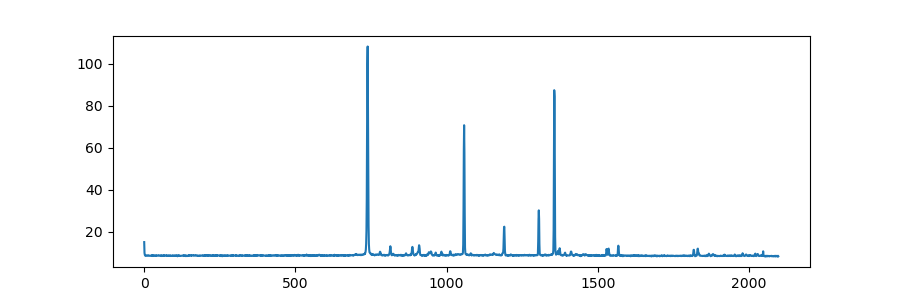

In [8]:
xpl,wav = pk.identify_widget(bex)

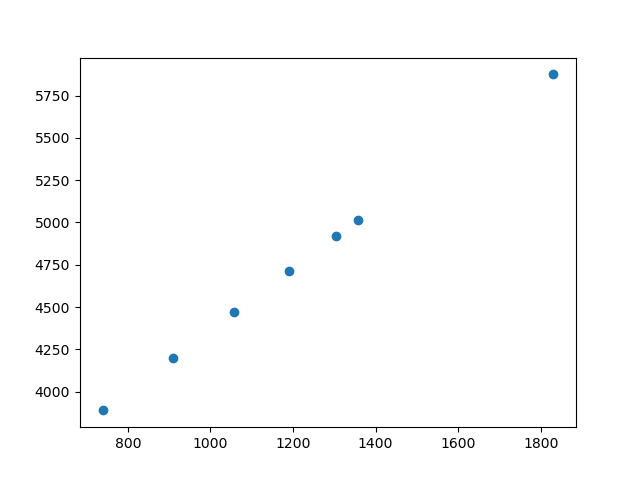

In [17]:
wav_b = wav
xpl_b = xpl

plt.figure()
plt.scatter(xpl_b,wav_b)

In [27]:
df = pd.DataFrame(data={'disp':np.repeat('B400', len(xpl_b)),
                        'pixel':xpl_b, 
                        'wave':wav_b})


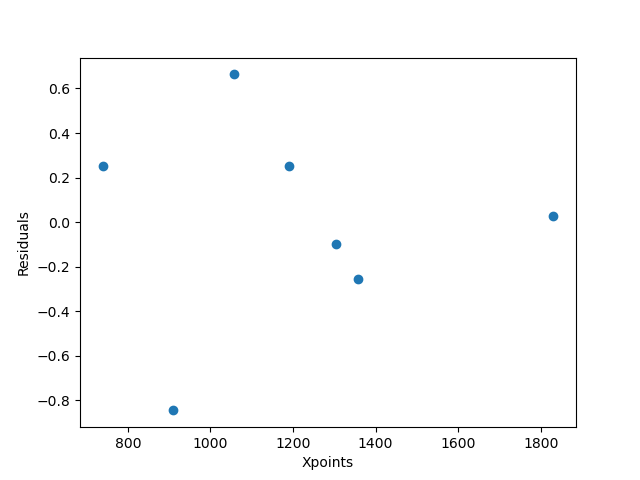

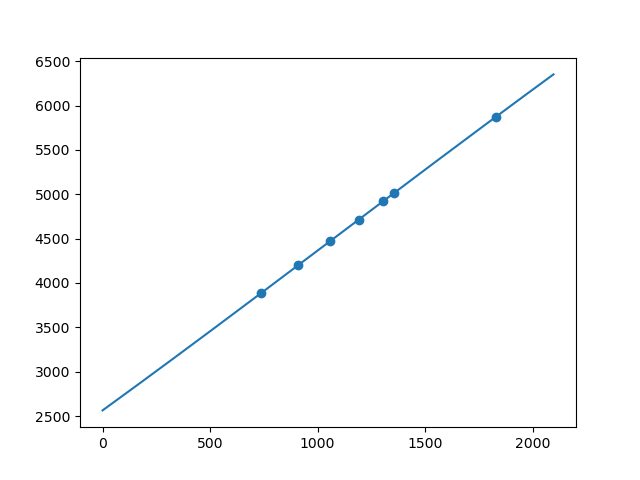

In [50]:
plt.figure()
b_fit = pk.fit_wavelength(bex, xpl_b, wav_b * u.angstrom, display=True, mode='spline', deg=1)

plt.figure()
plt.scatter(xpl_b, wav_b)
plt.plot(bex.spectral_axis, b_fit.spectral_axis)

In [47]:
sout = pd.DataFrame(data={'wave':b_fit.spectral_axis.value,
                          'flux':b_fit.flux.value})

sout.to_csv('../pykosmos/resources/arctemplates/DIS_B400.spec', 
                                index=False, index_label=False)

In [48]:
ls ../pykosmos/resources/arctemplates/

ArBlue0.86-high.spec  KrBlue0.86-high.spec  NeBlue1.18-ctr.spec
ArBlue1.18-ctr.spec   KrBlue1.18-ctr.spec   NeBlue2.0-low.spec
ArBlue2.0-low.spec    KrBlue2.0-low.spec    NeRed0.86-high.spec
ArRed0.86-high.spec   KrRed0.86-high.spec   NeRed1.18-ctr.spec
ArRed1.18-ctr.spec    KrRed1.18-ctr.spec    NeRed2.0-low.spec
ArRed2.0-low.spec     KrRed2.0-low.spec     README.md
DIS_B400.spec         NeBlue0.86-high.spec


# R300


    Instructions:
    ------------
    0) For proper interactive widgets, ensure you're using the Notebook backend
    in the Jupyter notebook, e.g.:
        %matplotlib notebook
    1) Click on arc-line features (peaks) in the plot. The Pixel Value box should update.
    2) Enter the known wavelength of the feature in the Wavelength box.
    3) Click the Assign button, a red line will be drawn marking the feature.
    4) When you've identified all your lines, stop the interaction for (or close) the figure.


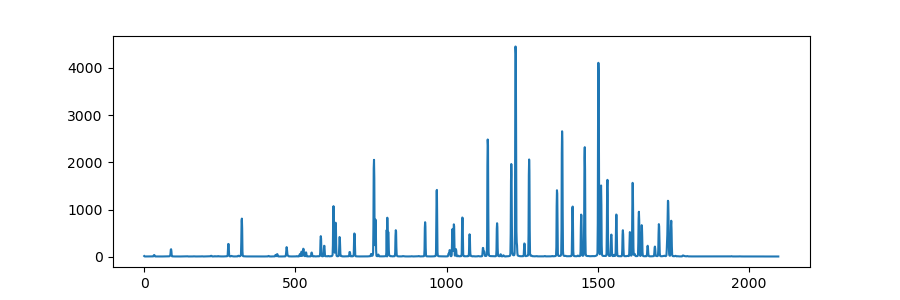

In [52]:
xpl,wav = pk.identify_widget(rex)

16


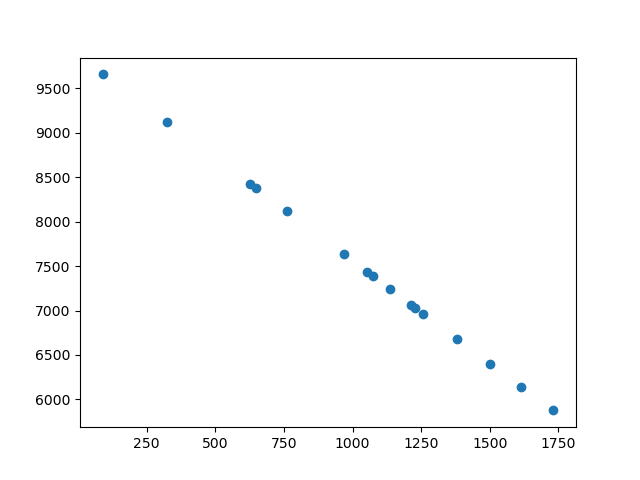

In [53]:
wav_r = wav
xpl_r = xpl
print(len(wav_r))

plt.figure()
plt.scatter(xpl_r,wav_r)

In [55]:
disp = np.repeat('B400', len(xpl_b))
xpl_big = xpl_b
wav_big = wav_b

In [56]:
disp = np.append(disp, np.repeat('R300', len(xpl_r)))
xpl_big = np.append(xpl_big, xpl_r)
wav_big = np.append(wav_big, wav_r)

In [58]:
df = pd.DataFrame(data={'disp':disp,
                        'pixel':xpl_big, 
                        'wave':wav_big})
df.to_csv('dis-low.csv')

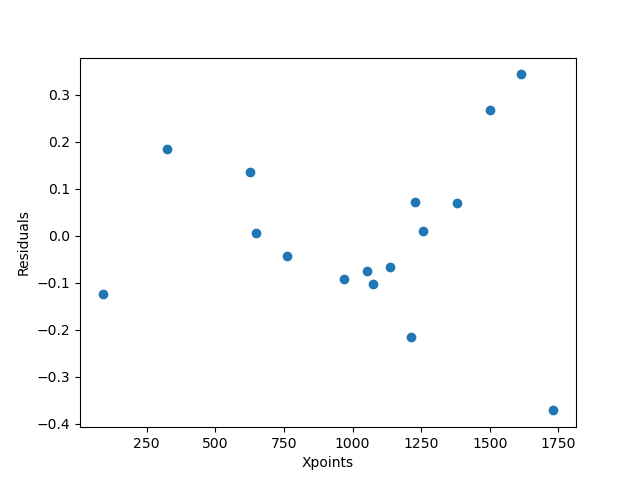

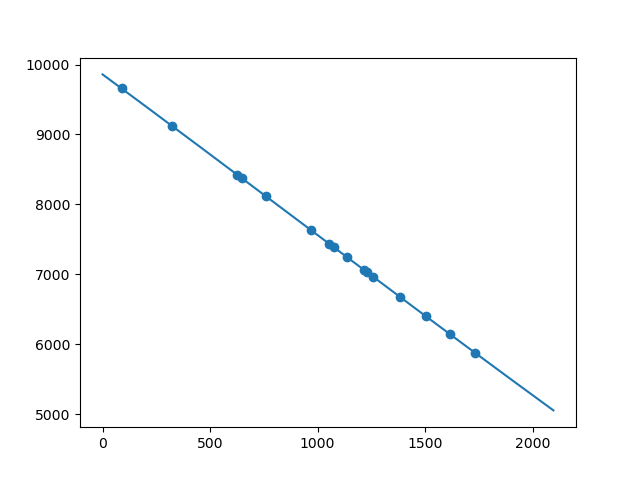

In [59]:
plt.figure()
r_fit = pk.fit_wavelength(rex, xpl_r, wav_r * u.angstrom, display=True, mode='spline', deg=1)

plt.figure()
plt.scatter(xpl_r, wav_r)
plt.plot(rex.spectral_axis, r_fit.spectral_axis)

In [60]:
sout = pd.DataFrame(data={'wave':r_fit.spectral_axis.value,
                          'flux':r_fit.flux.value})

sout.to_csv('../pykosmos/resources/arctemplates/DIS_R300.spec', 
                                index=False, index_label=False)

In [61]:
ls ../pykosmos/resources/arctemplates/

ArBlue0.86-high.spec  DIS_R300.spec         NeBlue0.86-high.spec
ArBlue1.18-ctr.spec   KrBlue0.86-high.spec  NeBlue1.18-ctr.spec
ArBlue2.0-low.spec    KrBlue1.18-ctr.spec   NeBlue2.0-low.spec
ArRed0.86-high.spec   KrBlue2.0-low.spec    NeRed0.86-high.spec
ArRed1.18-ctr.spec    KrRed0.86-high.spec   NeRed1.18-ctr.spec
ArRed2.0-low.spec     KrRed1.18-ctr.spec    NeRed2.0-low.spec
DIS_B400.spec         KrRed2.0-low.spec     README.md


# TEST IT
we've built a Red and Blue template... now let's test against another night's arc

In [62]:
# FROM:
# /data/epyc/projects/IGAP-Ha/H_alpha_Data/Q3UW10/UT210909
rarcfile = '/Users/james/Dropbox/research_projects/kosmos-testing/arc.0001r.fits'
barcfile = '/Users/james/Dropbox/research_projects/kosmos-testing/arc.0001b.fits'

# read and process in the ARC LAMP, just like a normal spectrum
barcimg = pk.proc(barcfile,trim=False)
rarcimg = pk.proc(rarcfile,trim=False)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [63]:
sci_trace = np.ones(barcimg.shape[1])*455

Text(0.5, 1.0, '/Users/james/Dropbox/research_projects/kosmos-testing/arc.0001r.fits')

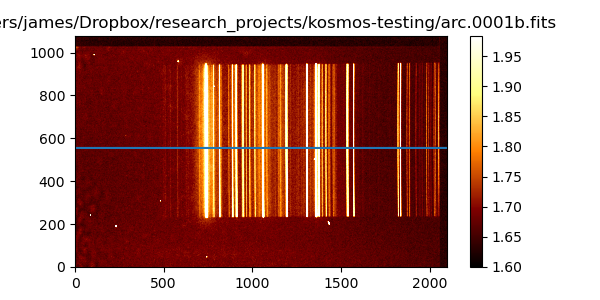

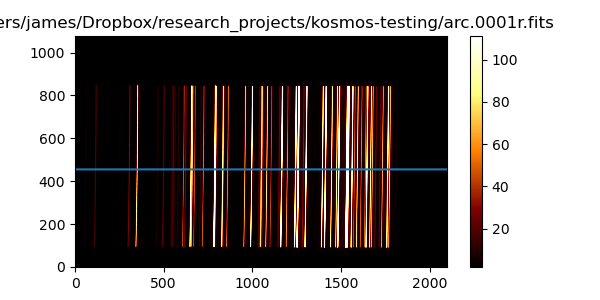

In [64]:
plt.figure(figsize=(6,3))
plt.imshow(barcimg, origin='lower', aspect='auto', cmap=plt.cm.afmhot)
plt.plot(np.arange(len(sci_trace)), sci_trace+100) # for illustration, overplot the trace 
plt.clim(np.percentile(barcimg, (5, 97)))
cb = plt.colorbar()
plt.title(barcfile)

plt.figure(figsize=(6,3))
plt.imshow(rarcimg, origin='lower', aspect='auto', cmap=plt.cm.afmhot)
plt.plot(np.arange(len(sci_trace)), sci_trace) # for illustration, overplot the trace 
plt.clim(np.percentile(rarcimg, (5, 97)))
cb = plt.colorbar()
plt.title(rarcfile)

/var/folders/8t/yh7p62792_b_y17g3f6wk0wm0000gn/T/ipykernel_36091/3817877127.py:1: DeprecationWarning: PyKOSMOS BoxcarExtract is now a wrapper for functions within specreduce.extract.
  rex = pk.BoxcarExtract(rarcimg, sci_trace, apwidth=5, skysep=5, skywidth=5, bkgd_sub=False, Saxis=0, Waxis=1)
/var/folders/8t/yh7p62792_b_y17g3f6wk0wm0000gn/T/ipykernel_36091/3817877127.py:2: DeprecationWarning: PyKOSMOS BoxcarExtract is now a wrapper for functions within specreduce.extract.
  bex = pk.BoxcarExtract(barcimg, sci_trace+100, apwidth=5, skysep=5, skywidth=5, bkgd_sub=False, Saxis=0, Waxis=1)


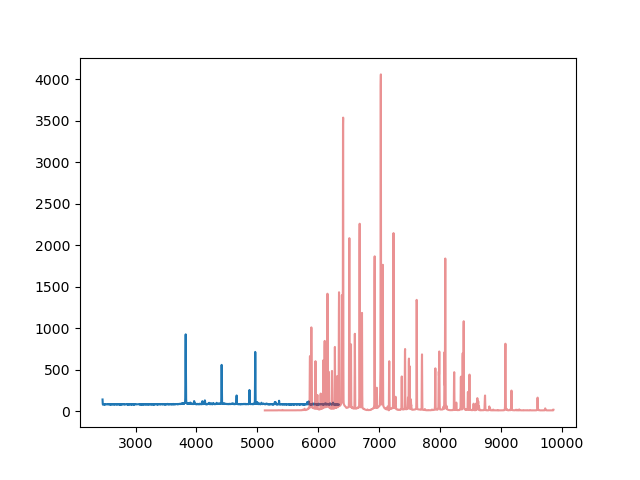

In [65]:
rex = pk.BoxcarExtract(rarcimg, sci_trace, apwidth=5, skysep=5, skywidth=5, bkgd_sub=False, Saxis=0, Waxis=1)
bex = pk.BoxcarExtract(barcimg, sci_trace+100, apwidth=5, skysep=5, skywidth=5, bkgd_sub=False, Saxis=0, Waxis=1)

wapproxb = (np.arange(barcimg.shape[1]) - barcimg.shape[1]/2) * barcimg.header['DISPDW'] + barcimg.header['DISPWC']
wapproxb = wapproxb * u.angstrom

wapproxr = (np.arange(rarcimg.shape[1]) - rarcimg.shape[1]/2)[::-1] * rarcimg.header['DISPDW'] + rarcimg.header['DISPWC']
wapproxr = wapproxr * u.angstrom

plt.figure()
plt.plot(wapproxb, bex.flux.value*10)
plt.plot(wapproxr, rex.flux, c='C3', alpha=0.5)

In [66]:
# what calibrated arc templates are available?
# (we should build some explicitly for ALL lamps at APO!)
pk.loadarctemplate(help=True)

['/Users/james/Dropbox/research_projects/pykosmos/pykosmos/resources/arctemplates/DIS_B400.spec',
 '/Users/james/Dropbox/research_projects/pykosmos/pykosmos/resources/arctemplates/KrRed0.86-high.spec',
 '/Users/james/Dropbox/research_projects/pykosmos/pykosmos/resources/arctemplates/DIS_R300.spec',
 '/Users/james/Dropbox/research_projects/pykosmos/pykosmos/resources/arctemplates/KrRed1.18-ctr.spec',
 '/Users/james/Dropbox/research_projects/pykosmos/pykosmos/resources/arctemplates/KrBlue1.18-ctr.spec',
 '/Users/james/Dropbox/research_projects/pykosmos/pykosmos/resources/arctemplates/KrBlue0.86-high.spec',
 '/Users/james/Dropbox/research_projects/pykosmos/pykosmos/resources/arctemplates/ArRed2.0-low.spec',
 '/Users/james/Dropbox/research_projects/pykosmos/pykosmos/resources/arctemplates/NeBlue2.0-low.spec',
 '/Users/james/Dropbox/research_projects/pykosmos/pykosmos/resources/arctemplates/ArRed1.18-ctr.spec',
 '/Users/james/Dropbox/research_projects/pykosmos/pykosmos/resources/arctemplate

In [67]:
rtemp = pk.loadarctemplate('DIS_R300.spec') # new
btemp = pk.loadarctemplate('DIS_B400.spec') # new


105


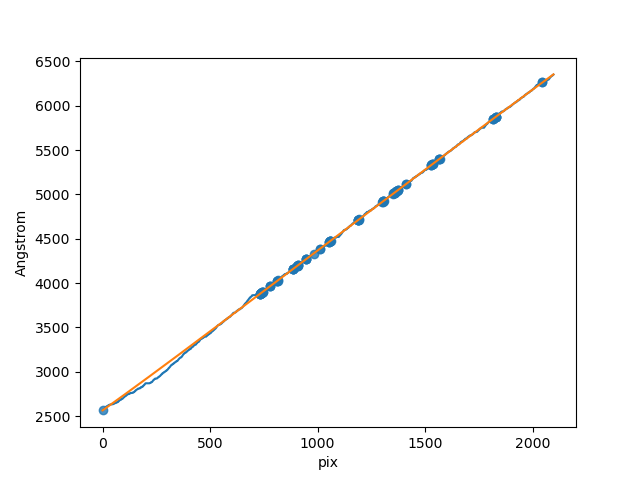

In [73]:
plt.figure()
sci_xpts, sci_wpts = pk.identify_dtw(bex, btemp, upsample=False, display=True, 
                   step_pattern='asymmetric', open_begin=True, open_end=True, 
                                     peak_spline=False, pthreshold=0.95, return_peaks=True)
print(len(sci_xpts))
# apply wavelength solution to science extraction
b_fit = pk.fit_wavelength(bex, sci_xpts, sci_wpts, display=False, mode='poly', deg=5)
plt.plot(bex.spectral_axis.value, b_fit.spectral_axis.value)

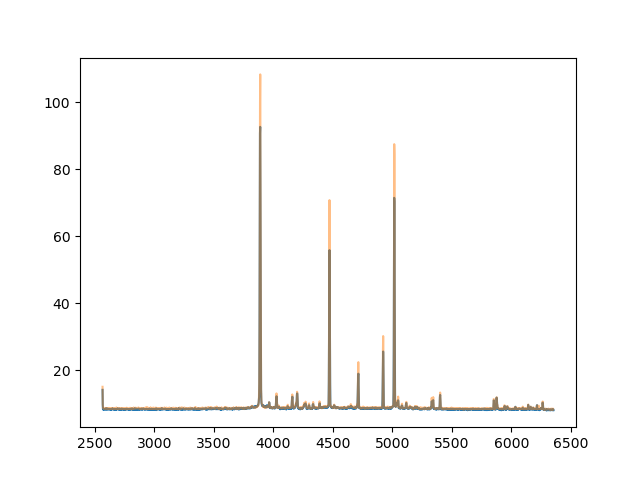

In [74]:
plt.figure()
plt.plot(b_fit.spectral_axis, b_fit.flux)
plt.plot(btemp.spectral_axis, btemp.flux, alpha=0.5)
# blue looks good, easy

210


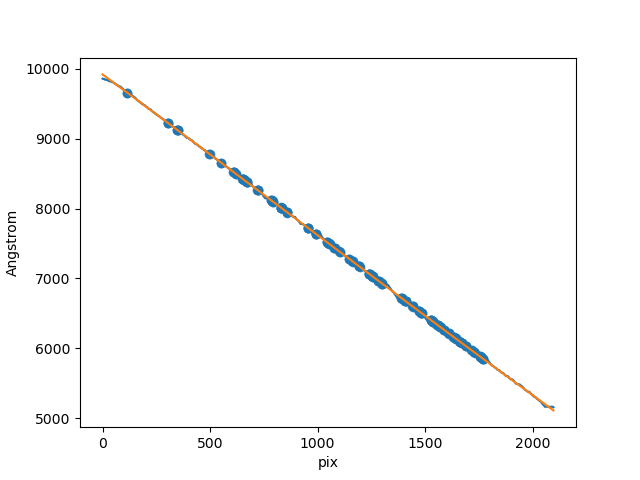

In [77]:
plt.figure()
sci_xpts, sci_wpts = pk.identify_dtw(rex, rtemp, upsample=False, display=True, 
                   step_pattern='asymmetric', open_begin=True, open_end=True, 
                                     peak_spline=False, pthreshold=0.90, return_peaks=True)
print(len(sci_xpts))
# apply wavelength solution to science extraction
r_fit = pk.fit_wavelength(rex, sci_xpts, sci_wpts, display=False, mode='poly', deg=5)
plt.plot(rex.spectral_axis.value, r_fit.spectral_axis.value)

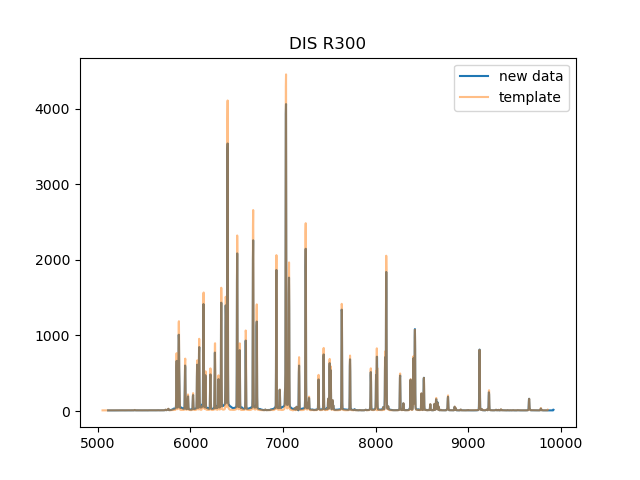

In [80]:
plt.figure()
plt.plot(r_fit.spectral_axis, r_fit.flux, label='new data')
plt.plot(rtemp.spectral_axis, rtemp.flux, alpha=0.5, label='template')
plt.title('DIS R300')
plt.legend()
# red looks nice too!

# Make pixel plots

 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
a floating-point value was expected. [astropy.wcs.wcs]
/var/folders/8t/yh7p62792_b_y17g3f6wk0wm0000gn/T/ipykernel_36091/3252618652.py:8: DeprecationWarning: PyKOSMOS BoxcarExtract is now a wrapper for functions within specreduce.extract.
  rex = pk.BoxcarExtract(rarcimg, sci_trace, apwidth=5, skysep=5, skywidth=5, bkgd_sub=False, Saxis=0, Waxis=1)
/var/folders/8t/yh7p62792_b_y17g3f6wk0wm0000gn/T/ipykernel_36091/3252618652.py:9: DeprecationWarning: PyKOSMOS BoxcarExtract is now a wrapper for functions within specreduce.extract.
  bex = pk.BoxcarExtract(barcimg, sci_trace+100, apwidth=5, skysep=5, skywidth=5, bkgd_sub=False, Saxis=0, Waxis=1)


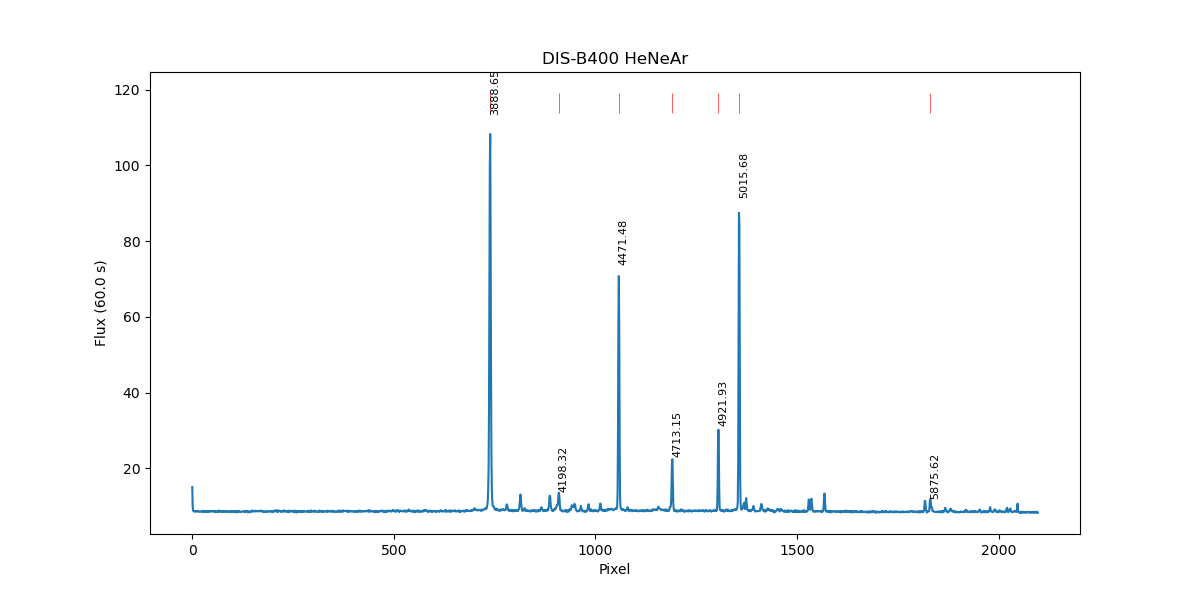

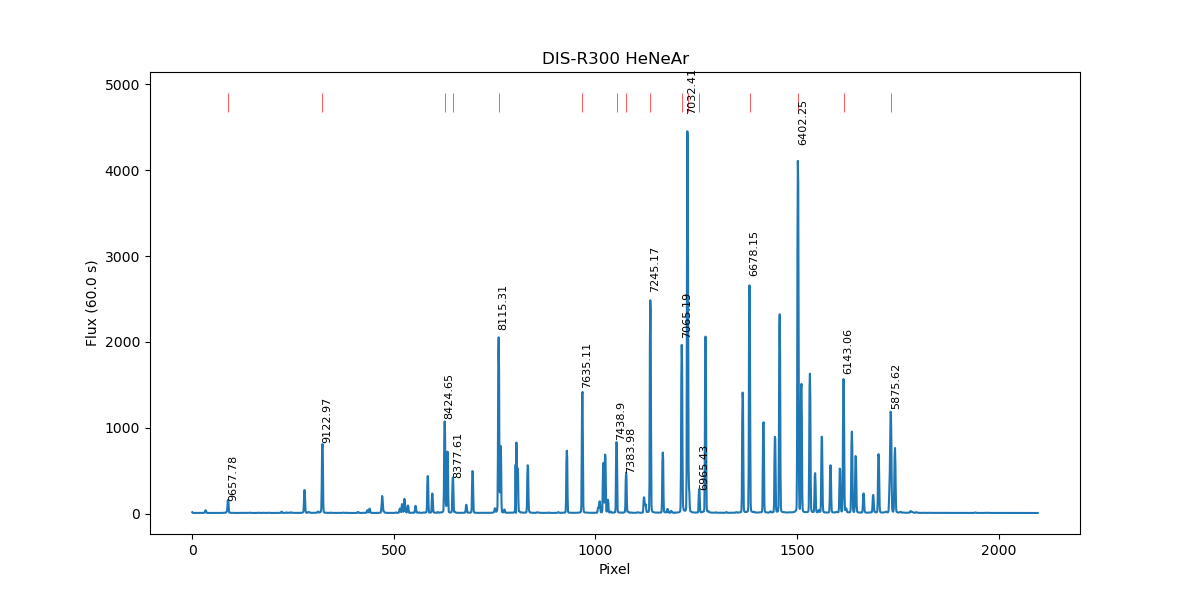

In [90]:
rarcfile = '/Users/james/Dropbox/research_projects/kosmos-testing/arc.0016r.fits'
barcfile = '/Users/james/Dropbox/research_projects/kosmos-testing/arc.0016b.fits'

# read and process in the ARC LAMP, just like a normal spectrum
barcimg = pk.proc(barcfile,trim=False)
rarcimg = pk.proc(rarcfile,trim=False)
sci_trace = np.ones(barcimg.shape[1])*555
rex = pk.BoxcarExtract(rarcimg, sci_trace, apwidth=5, skysep=5, skywidth=5, bkgd_sub=False, Saxis=0, Waxis=1)
bex = pk.BoxcarExtract(barcimg, sci_trace+100, apwidth=5, skysep=5, skywidth=5, bkgd_sub=False, Saxis=0, Waxis=1)


plt.figure(figsize=(12,6))
plt.plot(bex.spectral_axis, bex.flux, c='C0')
ee = (df['disp']=='B400')
plt.vlines(df['pixel'][ee], 1.05*np.max(bex.flux.value),1.1*np.max(bex.flux.value)
           ,color='r', lw=0.6, alpha=0.75)
for tt in range(sum(ee)):
    peak = 1.05*np.max(bex.flux.value[np.abs(bex.spectral_axis.value - df['pixel'].values[ee][tt]) < 1])
    plt.text(df['pixel'].values[ee][tt], peak, str(df['wave'].values[ee][tt]), 
             fontsize=8, rotation='vertical', color='k')

plt.xlabel('Pixel')
plt.ylabel('Flux ('+str(barcimg.header['EXPTIME'])+' s)')
plt.title('DIS-B400 HeNeAr')
plt.savefig('DIS_B400_HeNeAr_pixel.pdf', 
            dpi=150, bbox_inches='tight', pad_inches=0.25)


plt.figure(figsize=(12,6))
plt.plot(rex.spectral_axis, rex.flux, c='C0')
ee = (df['disp']=='R300')
plt.vlines(df['pixel'][ee], 1.05*np.max(rex.flux.value),1.1*np.max(rex.flux.value)
           ,color='r', lw=0.6, alpha=0.75)
for tt in range(sum(ee)):
    peak = 1.05*np.max(rex.flux.value[np.abs(rex.spectral_axis.value - df['pixel'].values[ee][tt]) < 1])
    plt.text(df['pixel'].values[ee][tt], peak, str(df['wave'].values[ee][tt]), 
             fontsize=8, rotation='vertical', color='k')

plt.xlabel('Pixel')
plt.ylabel('Flux ('+str(barcimg.header['EXPTIME'])+' s)')
plt.title('DIS-R300 HeNeAr')
plt.savefig('DIS_R300_HeNeAr_pixel.pdf', 
            dpi=150, bbox_inches='tight', pad_inches=0.25)

In [81]:
df

,disp,pixel,wave
0,B400,738.697683,3888.65
1,B400,909.219572,4198.32
2,B400,1057.965796,4471.48
3,B400,1190.452504,4713.15
4,B400,1304.967340,4921.93
5,B400,1356.436419,5015.68
6,B400,1830.606291,5875.62
7,R300,88.700711,9657.78
8,R300,322.767387,9122.97
9,R300,626.063099,8424.65
